In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

menu_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

menu_retriever = menu_db.as_retriever(
    search_kwargs={'k':2}
)

wine_db = Chroma(
   embedding_function=embeddings_model,   
   collection_name="restaurant_wine",
   persist_directory="./chroma_db",
)

wine_retriever = wine_db.as_retriever(
    search_kwargs={'k':2}
)


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
menu_query = "시그니처 스테이크의 가격과 특징은 무엇인가요?"

menu_docs = menu_retriever.invoke(menu_query)

print(f"검색 문서 수 : {len(menu_docs)}")
for doc in menu_docs:
    print(f"문서 내용  : {doc.page_content}")

wine_query = "스테이크와 어울리는 와인을 추천해 주세요."

wine_docs = wine_retriever.invoke(wine_query)

print(f"검색 문서 수 : {len(wine_docs)}")
for doc in wine_docs:
    print(f"문서 내용  : {doc.page_content}")

검색 문서 수 : 2
문서 내용  : 1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
문서 내용  : 8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
검색 문서 수 : 2
문서 내용  : 9. 샤토 디켐 2015
   • 가격: ₩800,000 (375ml)
   • 주요 품종: 세미용, 소비뇽 블랑
   • 설명: 보르도 소테른 지역의 legendary 디저트 와인입니다. 아프리콧, 복숭아, 파인애플의 농축된 과실향과 함께 꿀, 사프란, 바닐라의 복잡한 향이 어우러집니다. 놀라운 농축도와 균형 잡힌 산도, 긴 여운이 특징이며, 100년 이상 숙성 가능한 와인으로 알려져 있습니다.
문서 내용  : 10. 그랜지 2016
    • 가격: ₩950,000
    • 주요 품종: 시라
    • 설명: 호주의 대표적인 아이콘 와인입니다. 블랙베리, 자두, 블랙 올리브의 강렬한 과실향과 함께 유칼립투스, 초콜릿, 가죽의 복잡한 향이 어우러집니다. 풀바디이며 강렬한 타닌과 산도가 특징적입니다. 놀라운 집중도와 깊이, 긴 여운을 자랑하며, 수십 년의 숙성 잠재력을 가집니다.


In [ ]:
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

# class GraphState(MessagesState): #MessagesState를 넣어주는 것으로
    
#     # messages 키를 기본적으로 제공 -> 서로 대화했던 내용을 유지하는 필드

#     documents : List[Document]
#     grade : float # 답변의 수준을 저장하는 필드, 일정 성능 이상의 답변을 원함.
#     num_generation : int # 높은 수준의 답변을 얻기 위해, 최대 몇 번의 반복을 돌릴 것인지

class GraphState(MessagesState):
    # messages 키를 기본적으로 제공
    last_user_message: str
    documents: List[Document]
    grade: float
    num_generation: int

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = menu_db.as_retriever(
    search_kwargs={"k": 2}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "채식주의자를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

제공된 메뉴 중에서는 채식주의자를 위한 옵션이 없습니다. 그러나 일반적으로 채식주의자에게 적합한 메뉴를 고려할 때, 신선한 채소, 과일, 곡물 및 식물성 단백질을 포함한 요리를 선택하는 것이 좋습니다.

채식주의자를 위한 메뉴를 원하신다면, 아보카도와 신선한 채소를 사용한 샐러드나, 채소 스튜, 또는 다양한 곡물과 채소로 만든 그레인 보울 같은 요리를 추천드립니다. 식당에 문의하여 채식 옵션이 있는지 확인해 보시는 것도 좋은 방법입니다.


In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

# RAG 수행 함수 정의
def retrieve_and_respond(state: GraphState):
    # last_human_message = state['messages'][-1] #현재 정확히 어떤 것이 들어가있는가?
    
    if "last_user_message" not in state:
        last_human_message = state['messages'][-1]
        query = last_human_message.content
        state["last_user_message"] = query
    else:
        query = state["last_user_message"]

    # HumanMessage 객체의 content 속성에 접근
    query = last_human_message.content
    
    # 문서 검색
    retrieved_docs = retriever.invoke(query)
    
    # 응답 생성
    response = rag_chain.invoke(query)
    
    # 검색된 문서와 응답을 상태에 저장
    return {
        "messages": [AIMessage(content=response)],
        "documents": retrieved_docs
    }

In [ ]:
from pydantic import BaseModel, Field

class GradeResponse(BaseModel):
    "A score for answers"
    score: float = Field(..., ge=0, le=1, description="A score from 0 to 1, where 1 is perfect")
    explanation: str = Field(..., description="An explanation for the given score")

# 답변 품질 평가 함수
def grade_answer(state: GraphState):
    messages = state['messages']
    question = messages[-2].content # 나의 질문
    answer = messages[-1].content # 질문에 대한 AI 의 대답
    context = format_docs(state['documents'])

    # grading_system = """You are an expert grader. 
    # Grade the following answer based on its relevance and accuracy to the question, considering the given context. 
    # Provide a score from 0 to 1, where 1 is perfect, along with an explanation."""

    grading_system = """ 
    당신은 전문가 채점자입니다. 당신의 임무는 두 가지를 모두 바탕으로 답을 **엄격히** 평가하는 것입니다:
    1. 질문과의 관련성
    2. 제공된 컨텍스트의 사용

    답변이 문맥을 적절히 활용하지 못하거나 문맥이 질문과 무관한 경우, 답변이 정중하거나 합리적으로 보일지라도 **낮은 점수**를 주세요. 
    question 내용에서 context에 없는 메뉴를 찾으면 특히 낮은 점수를 주세요.
    answer 내용에 "정보가 없습니다" 내용이 있으면 더 낮은 점수를 주세요.
    답변이 반복적이거나 관련 응답을 여러 번 제공하지 않는 경우 **점수를 벌점**해야 합니다.
    답변이 "맥락은 관련이 없다"고 인정하더라도, 제공된 문맥을 사용하지 않았기 때문에 **낮은 점수** (≤ 0.3)를 주어야 합니다.

    문맥이 직접적으로 뒷받침하지 않는 한 정중한 거절이나 반복적인 답변에 대해 높은 점수를 주지 마세요.

    다음 규칙을 사용하세요:
    - 문맥을 이용한 완벽한 답변: 1.0
    - 부분적으로 올바르지만 모호한 문맥 사용: 0.5–   - 답변이 컨텍스트를 사용하지 않거나 전혀 사용할 수 없습니다: 0.0–0.3
    """

    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse) #GradeResponse 형태로 리턴 받기 위해서
    
    grade_response = grading_chain.invoke({
        "question": question,
        "context": context,
        "answer": answer
    })

    # 답변 생성 횟수를 증가 
    num_generation = state.get('num_generation', 0)
    num_generation += 1
    
    return {"grade": grade_response.score, "num_generation": num_generation}

In [15]:
from typing import Literal


def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    print("----GRADTING---")
    print("Grade Score: ", state["grade"])

    # 답변 생성 횟수가 3회 이상이면 "generate"를 반환
    if state["num_generation"] > 2: 
        return "generate"    
    
    # 답변 품질 평가점수가 0.7 미만이면 RAG 체인을 다시 실행 
    if state["grade"] < 0.7:  
        return "retrieve_and_respond"
    else:
        return "generate"

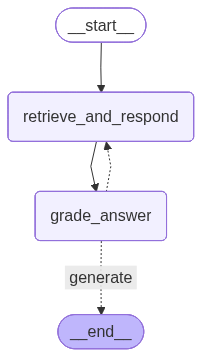

In [16]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 설정
builder = StateGraph(GraphState)
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

builder.add_edge(START, "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", "grade_answer")
builder.add_conditional_edges(
    "grade_answer",
    should_retry,
    {
        "retrieve_and_respond": "retrieve_and_respond",
        "generate": END
    }
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
from pprint import pprint

# 초기 상태
initial_state = {
    "messages": [HumanMessage(content="스테이크의 가격은 얼마고 어떤 특징이 있니?")],
}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state['messages'])

----GRADTING---
Grade Score:  1.0
최종 상태: [HumanMessage(content='스테이크의 가격은 얼마고 어떤 특징이 있니?', additional_kwargs={}, response_metadata={}, id='495125a6-b97b-4a2b-8c2b-b78e93fbcd64'), AIMessage(content='안심 스테이크 샐러드의 가격은 ₩26,000입니다. 이 요리는 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.', additional_kwargs={}, response_metadata={}, id='501b91f4-5598-49a7-8ad3-a1eaef69d953')]
